In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sys
sys.path.append('/dfs/scratch0/vschen/metal')

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
def visualize_data(X, Y, C, L):
    # show data by class
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 2, 1)
    plt.title('Data by Classes')
    plt.scatter(X[Y==1,0], X[Y==1,1], label="$y=+1$", c='C1')
    plt.scatter(X[Y==-1,0], X[Y==-1,1], label="$y=-1$", c='C0')
    plt.xlim(-8, 8)
    plt.ylim(-8, 8)
    plt.legend()

    # show data by slice
    plt.subplot(2, 2, 2)
    plt.title('Data by Slice')
    plt.scatter(X[C==0,0], X[C==0,1], label="$S_0$", c='C0')
    plt.scatter(X[C==1,0], X[C==1,1], label="$S_1$", c='C1')
    plt.scatter(X[C==2,0], X[C==2,1], label="$S_2$", c='C2')
    plt.xlim(-8, 8)
    plt.ylim(-8, 8)
    plt.legend()

    # LFs targeting slices
    plt.subplot(2, 2, 3)
    plt.title('LFs ($\lambda_i$) Targeting Slices ($S_i$)')
    plt.scatter(X[L[:,0]!=0,0], X[L[:,0]!=0,1], label="$\lambda_0$", c='C0')
    plt.scatter(X[L[:,1]!=0,0], X[L[:,1]!=0,1], label="$\lambda_1$", c='C1')
    plt.scatter(X[L[:,2]!=0,0], X[L[:,2]!=0,1], label="$\lambda_2$", c='C2')
    plt.xlim(-8, 8)
    plt.ylim(-8, 8)
    plt.legend()
    
    plt.subplot(2, 2, 4)
    plt.title('$\lambda_2$ accuracy')
    plt.scatter(X[L[:,2]==1,0], X[L[:,2]==1,1], label="$\lambda_2=+1$", s=0.1, c='C1')
    plt.scatter(X[L[:,2]==-1,0], X[L[:,2]==-1,1], label="$\lambda_2=-1$", s=0.1, c='C0')
    plt.xlim(-8, 8)
    plt.ylim(-8, 8)
    plt.legend()
    plt.show()


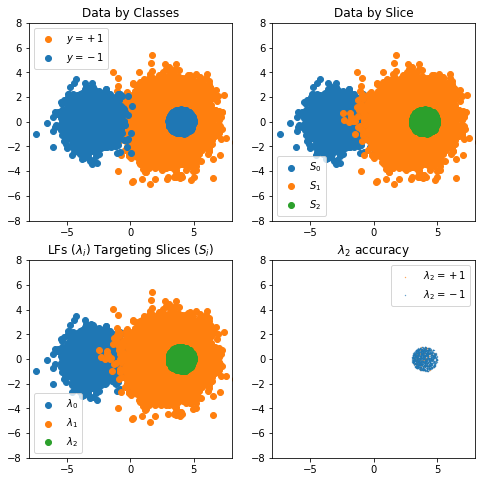

In [ ]:
from simulate import data_config as config
from synthetics_utils import generate_synthetic_data
X, Y, C, L = generate_synthetic_data(config)
visualize_data(X, Y, C, L)

In [ ]:
# from simulate import data_config as config
# X, Y, C, L = generate_synthetic_data(config, 'op', 0.5)
# visualize_data(X, Y, C, L)

In [ ]:
# X, Y, C, L = generate_synthetic_data(config, 'acc', 0.5)
# visualize_data(X, Y, C, L)

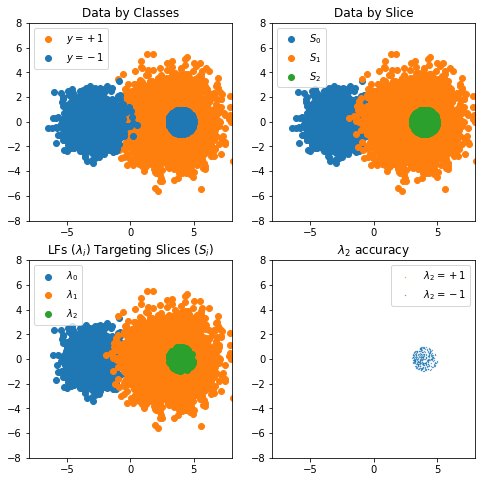

In [ ]:
from simulate import data_config as config
config['accs'][2] = 1.0
X, Y, C, L = generate_synthetic_data(config, 'cov', 0.2)
visualize_data(X, Y, C, L)

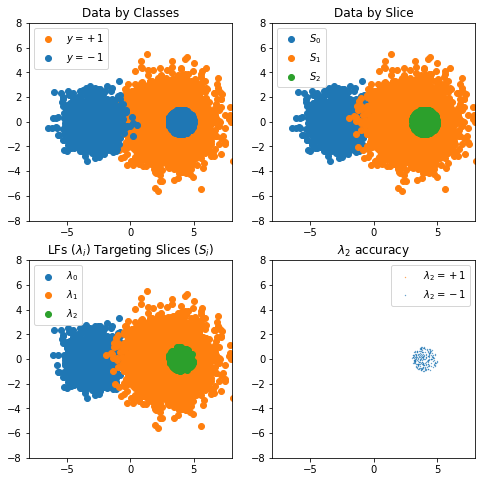

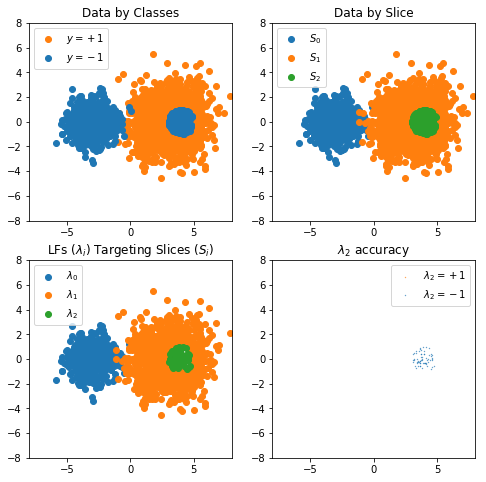

In [ ]:
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
Y_train, Y_test = Y[:split_idx], Y[split_idx:]
C_train, C_test = C[:split_idx], C[split_idx:]
L_train, L_test = L[:split_idx], L[split_idx:]
visualize_data(X_train, Y_train, C_train, L_train)
visualize_data(X_test, Y_test, C_test, L_test)

## Simulate

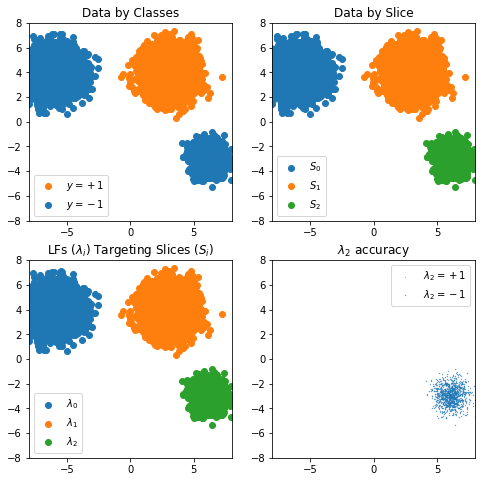

{'N': 10000,
 'mus': [array([-6,  4]), array([3, 4]), array([ 6, -3])],
 'labels': [-1, 1, -1],
 'props': [0.45, 0.45, 0.1],
 'variances': [1, 1, 0.5],
 'head_config': None,
 'accs': array([1., 1., 1.]),
 'covs': array([1., 1., 1.])}

In [ ]:
from simulate import data_config as config
from synthetics_utils import generate_synthetic_data

config = {
    # data generation
    "N": 10000, # num data points
    "mus": [
        np.array([-6, 4]), # Mode 1: Y = -1
        np.array([3, 4]), # Mode 2: Y = 1,
        np.array([6, -3])
    ],
    "labels": [-1, 1, -1], # labels of each slice
    "props": [0.45, 0.45, 0.1], # proportion of data in each mode
    "variances": [1, 1, 0.5], # proportion of data in each mode
    "head_config": None,

    "accs": np.array([1., 1., 1.0]), # default accuracy of LFs
    "covs": np.array([1., 1., 1.]), # default coverage of LFs
}
X, Y, C, L = generate_synthetic_data(config)
visualize_data(X, Y, C, L)
config

In [ ]:
%%time

# # Flip the signs
# config['labels'] = [1, -1]
# config['head_config']['slice_label'] = 1

experiment = "[10x6]_bs256"
X_VAR = "cov"
X_VAL = 1.0

from simulate import simulate
experiment_config = {
    "num_trials": 1,
#     "x_range": np.linspace(0, 1.0, 5),
    "x_range": [X_VAL],    
    "x_var": X_VAR,
    "input_module_kwargs": {
       'input_dim': 2,
#        'middle_dims': [10, 10, 10, 10, 10, 10],
        'middle_dims': [10, 10, 10],
       'bias': True
     },
    "train_kwargs": {
        "batch_size":256,
        "n_epochs":50,
        "print_every":10,
        "validation_metric":"accuracy",
        "disable_prog_bar":True,
        "verbose":True,
        "l2": 0,
        "lr": 1e-3,
        "checkpoint_runway": 5
    },
    "train_prop": 0.8,
    "tensorboard_logdir": f"./run_logs/{experiment}"
}
baseline_scores, manual_scores, attention_scores = \
    simulate(config, generate_synthetic_data, experiment_config)

  0%|          | 0/1 [00:00<?, ?it/s]

Simulating: cov=1.0
No checkpoints will be saved in the first checkpoint_runway=5 iterations.
[E:0]	Train Loss: 0.003	Dev accuracy: 0.553
Saving model at iteration 5 with best score 0.447
Saving model at iteration 6 with best score 0.468
Saving model at iteration 7 with best score 0.545
[E:10]	Train Loss: 0.003	Dev accuracy: 0.371
[E:20]	Train Loss: 0.003	Dev accuracy: 0.530
[E:30]	Train Loss: 0.003	Dev accuracy: 0.528
[E:40]	Train Loss: 0.003	Dev accuracy: 0.529
[E:49]	Train Loss: 0.003	Dev accuracy: 0.536
Restoring best model from iteration 7 with score 0.545
Finished Training
Accuracy: 0.545
        y=1    y=2   
 l=1    888    903   
 l=2     6     203   
No checkpoints will be saved in the first checkpoint_runway=5 iterations.
[E:0]	Train Loss: 0.003	Dev accuracy: 0.553
Saving model at iteration 5 with best score 0.553
[E:10]	Train Loss: 0.003	Dev accuracy: 0.553
Saving model at iteration 12 with best score 0.784
Saving model at iteration 13 with best score 0.896
Saving model at i

In [ ]:
attention_scores

In [ ]:
def get_slice_scores(scores, key=0.9):
    S0 = np.mean([s['S0'] for s in scores[key]])
    S1 = np.mean([s['S1'] for s in scores[key]])
    S2 = np.mean([s['S2'] for s in scores[key]])
    overall = np.mean([s['overall'] for s in scores[key]])    
    return {'S0':S0, 'S1':S1, 'S2':S2, 'overall':overall}

In [ ]:
for k in baseline_scores.keys():
    print (k)
    print ('base:', get_slice_scores(baseline_scores, k))
    print ('manual:', get_slice_scores(manual_scores, k))
    print ('attention:', get_slice_scores(attention_scores, k))

In [ ]:
results = {
    'baseline': dict(baseline_scores),
    'manual': dict(manual_scores),
    'attention': dict(attention_scores)
}

from synthetics_utils import plot_slice_scores
plot_slice_scores(results, 'S2', xlabel='Head Acc.')
plt.show()
plot_slice_scores(results, 'S1', xlabel='Head Acc.')
plt.show()
plot_slice_scores(results, 'S0', xlabel='Head Acc.')
plt.show()
plot_slice_scores(results, 'overall', xlabel='Head Acc.')